In [1]:
%matplotlib inline
import math
import pandas as pd
import pylab as p
alpha = 0.05
unordered_nominal_columns = ['Most_Important_Issue', 'Main_transportation', 'Occupation']


def convert_to_bool(df, *column_names):
    for column_name in column_names:
        df[column_name] = df[column_name].map(lambda x: 1 if x == "Yes" else (0 if x == 'No' else None))


def identify_and_set_correct_types(df):
    # boolean columns: Looking_at_poles_results Married Will_vote_only_large_party Financial_agenda_matters Voting_Time Gender
    convert_to_bool(df, 'Looking_at_poles_results', 'Married', 'Will_vote_only_large_party', 'Financial_agenda_matters')
    df['Gender'] = df['Gender'].map(lambda x: 1 if x == 'Male' else (0 if x == 'Female' else None))

    # Ordered nominal columns: Age_group
    df['Age_group'] = df['Age_group'].map(lambda x: 1 if x == "Below_30" else (2 if x == "30-45" else (3 if x == "45_and_up" else None)))
    df['Age_group'] = df['Age_group'].astype('category', ordered=True)
    df['Voting_Time'] = df['Voting_Time'].map(lambda x: 1 if x == 'By_16:00' else (2 if x == 'After_16:00' else None))
    df['Voting_Time'] = df['Voting_Time'].astype('category', ordered=True)

#     for col in unordered_nominal_columns:
#         df[col] = df[col].astype('category', ordered=False)

    return df


def nominal_to_numeric(df):
    # we are losing the missing data here
    for col in unordered_nominal_columns:
        partial = pd.get_dummies(df[col], col, '_')
        df = df.join(partial)
        del df[col]
    return df


def print_missing_values(df):
    print '\n\nMissing values:'
    for col in df.columns.values:
        misCount = df[col].isnull().sum()
        if misCount > 0:
            print '%s: %s missing values' % (col, misCount)


def data_imputation(df):
    # method='nearset'
    #return df.interpolate(method='linear')

#   # median
#    for col in df.columns.values:
#        df[col] = df[col].fillna(df[col].median())
        
    return df

def plot_log_density_function(df, column):
    plot_density_function(df, column, lambda x: math.log(x))


def plot_density_function(df, column, trans=lambda x: x):
    df[column].plot(kind='kde')    
    # p.savefig('foo.png')
    # p.clf()
    p.show()


In [2]:
df = pd.read_csv('./dataset/ElectionsData.csv')
# df = identify_and_set_correct_types(df)
df.dropna(inplace=True)
df.describe()


,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Residancy_Altitude,Yearly_ExpensesK,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,...,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years
count,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,...,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000
mean,5.521180,444.880470,74052.534755,148.293490,506.570169,0.503743,0.497976,4.979805,4.980646,4.945780,...,24.767447,819001.020307,50.095022,34272.714537,72.864838,1.994368,952.243446,10.481268,680.223839,0.689765
std,2.869735,330.340002,61917.142758,110.113334,172.404935,0.288324,0.286469,2.892392,2.898338,2.889963,...,3.230392,341495.930621,28.884903,55711.588576,20.197879,1.267355,178.224152,5.771570,154.123060,1.075221
min,1.000000,-394.030092,-81744.489527,-131.343364,0.349801,0.000193,0.000021,0.000616,0.000258,0.000580,...,1.070541,524.288150,0.005066,13.097572,30.000000,0.000000,29.055030,1.000000,3.153985,0.000000
25%,3.000000,196.448728,30020.492226,65.482909,402.951062,0.255969,0.249368,2.452850,2.467503,2.439931,...,23.956869,659876.831126,25.137525,4389.120819,60.000000,1.000000,875.080861,5.000000,610.799487,0.000000
50%,6.000000,365.139384,57808.027114,121.713128,445.945615,0.504244,0.496565,4.978188,4.944264,4.956069,...,24.674333,742475.977090,50.486613,14953.597901,70.000000,2.000000,945.740652,11.000000,680.964899,0.000000
75%,8.000000,622.052593,100501.179351,207.350864,596.617700,0.752151,0.742686,7.452653,7.523308,7.394469,...,25.896559,900862.356499,75.147797,43211.732016,90.000000,3.000000,1022.346527,15.000000,771.114540,1.000000
max,10.000000,2290.716172,640346.644820,763.572057,1000.000000,0.999966,0.999926,9.999888,9.999543,9.999985,...,31.622777,2002009.297226,99.974064,583815.858711,100.000000,7.000000,1499.648613,20.000000,999.999049,10.000000


#### Remove not possible values

In [3]:
df=df[df['Avg_monthly_expense_when_under_age_21']>=0]
df=df[df['AVG_lottary_expanses']>=0]
df.describe()

,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Residancy_Altitude,Yearly_ExpensesK,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,...,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years
count,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,...,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000,8146.000000
mean,5.522956,446.468968,74321.716110,148.822989,506.541709,0.503540,0.498063,4.982672,4.979372,4.945439,...,24.766381,818976.248267,50.108953,34356.545844,72.838203,1.994108,952.181322,10.479254,680.166733,0.689786
std,2.870142,329.330048,61774.731444,109.776683,172.418320,0.288304,0.286474,2.892573,2.899884,2.889516,...,3.233278,341751.947436,28.891508,55763.009320,20.203327,1.266159,178.385937,5.771939,154.175791,1.075030
min,1.000000,3.988911,44.957092,1.329637,0.349801,0.000193,0.000021,0.000616,0.000258,0.000580,...,1.070541,524.288150,0.005066,13.097572,30.000000,0.000000,29.055030,1.000000,3.153985,0.000000
25%,3.000000,198.312808,30209.803690,66.104269,403.090898,0.255858,0.249304,2.460754,2.466062,2.440019,...,23.957544,659979.428242,25.176596,4445.878947,60.000000,1.000000,875.068070,5.000000,610.950290,0.000000
50%,6.000000,366.621173,57927.372083,122.207058,445.909060,0.503419,0.496640,4.983254,4.943491,4.956069,...,24.673545,742408.532152,50.469529,15066.772072,70.000000,2.000000,945.653768,11.000000,680.877369,0.000000
75%,8.000000,623.146085,100656.179475,207.715362,596.228952,0.752043,0.742688,7.458120,7.522793,7.394158,...,25.892530,900211.299493,75.171680,43363.387509,90.000000,3.000000,1022.235209,15.000000,770.758095,1.000000
max,10.000000,2290.716172,640346.644820,763.572057,1000.000000,0.999966,0.999926,9.999888,9.999543,9.999985,...,31.622777,2002009.297226,99.974064,583815.858711,100.000000,7.000000,1499.648613,20.000000,999.999049,10.000000


In [4]:
import numpy as np
# Identify which of the orginal features are objects
ObjFeat=df.keys()[df.dtypes.map(lambda x: x=='object')]

# Transform the original features to categorical
# Creat new 'int' features, resp.

for f in ObjFeat:
    df[f] = df[f].astype("category")
    df[f+"Int"] = df[f].cat.rename_categories(range(df[f].nunique())).astype(int)
    df.loc[df[f].isnull(), f+"Int"] = np.nan #fix NaN conversion
    df[f]=df[f+"Int"]
    del df[f+"Int"]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8146 entries, 0 to 9998
Data columns (total 38 columns):
Vote                                             8146 non-null float64
Occupation_Satisfaction                          8146 non-null float64
Avg_monthly_expense_when_under_age_21            8146 non-null float64
AVG_lottary_expanses                             8146 non-null float64
Most_Important_Issue                             8146 non-null float64
Avg_Residancy_Altitude                           8146 non-null float64
Looking_at_poles_results                         8146 non-null float64
Yearly_ExpensesK                                 8146 non-null float64
Married                                          8146 non-null float64
Gender                                           8146 non-null float64
Voting_Time                                      8146 non-null float64
Financial_balance_score_(0-1)                    8146 non-null float64
%Of_Household_Income                     

### Convert to Numpy array

In [6]:
df_X_noNaN = df.drop(['Vote'], axis=1).values
df_Y_noNaN = df.Vote.values

## Filters (Features Selection)

### Applying chi2 for nominal values:

In [7]:
from sklearn.feature_selection import chi2
v=chi2(df_X_noNaN, df_Y_noNaN)[1]

i=0
features_to_keep=[]

for c in df.drop(['Vote'], axis=1).columns:    
    if c in ObjFeat:
        print  str(v[i]) +": " + c
        if v[i]<alpha:
            features_to_keep.append(c)            
    i+=1

0.0: Most_Important_Issue
0.0: Looking_at_poles_results
2.11157371268e-116: Married
0.979486951977: Gender
0.543189363847: Voting_Time
2.5239068613e-76: Will_vote_only_large_party
0.628214501735: Age_group
0.25193533582: Main_transportation
0.0657004618364: Occupation
0.0: Financial_agenda_matters


In [8]:
features_to_keep

['Most_Important_Issue',
 'Looking_at_poles_results',
 'Married',
 'Will_vote_only_large_party',
 'Financial_agenda_matters']

### Now we would like to apply ANOVA for the numeric values
but there are 2 assumptions:
- The distribution in each group is normal.
- The variance in each group is the same.

#### Testing for normal distribution:

0.0: Occupation_Satisfaction
0.0: Avg_monthly_expense_when_under_age_21
0.0: AVG_lottary_expanses
0.0: Avg_Residancy_Altitude
0.0: Yearly_ExpensesK
2.10194769649e-44: Financial_balance_score_(0-1)


/Users/Itay/miniconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1082: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


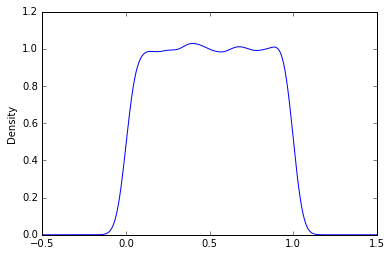

1.07899981753e-43: %Of_Household_Income


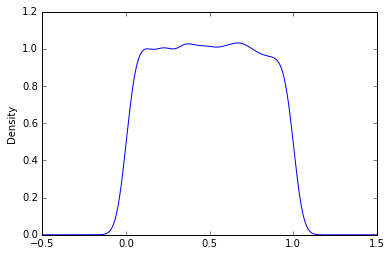

1.12103877146e-44: Avg_government_satisfaction


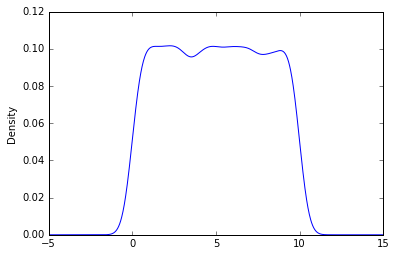

5.6051938573e-45: Avg_education_importance


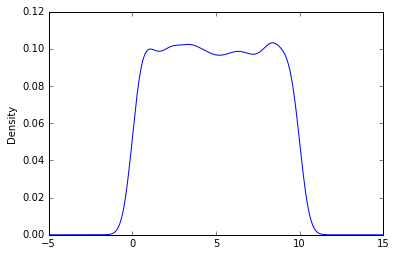

2.80259692865e-44: Avg_environmental_importance


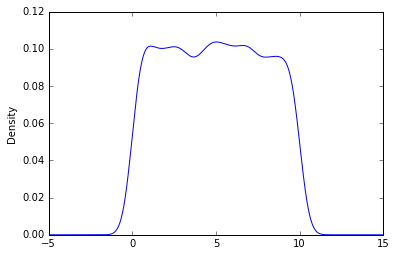

6.86636247519e-44: Avg_Satisfaction_with_previous_vote


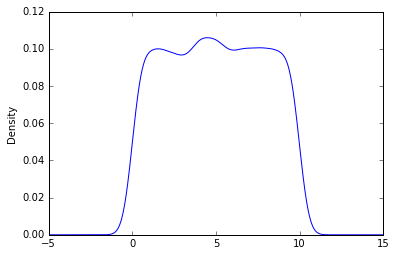

3.78350585368e-44: Avg_monthly_income_all_years


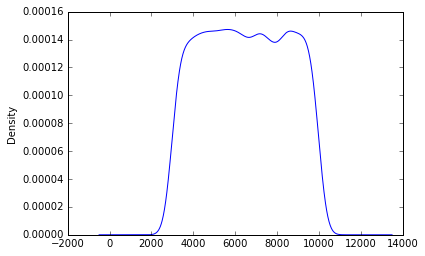

2.38220738935e-44: %Time_invested_in_work


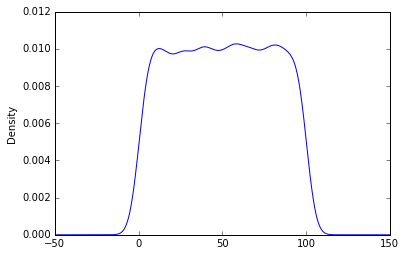

0.0: Yearly_IncomeK
0.0: Avg_monthly_expense_on_pets_or_plants
0.0: Avg_monthly_household_cost
0.0: Phone_minutes_10_years
0.0: Avg_size_per_room
0.0: Weighted_education_rank
1.26116861789e-44: %_satisfaction_financial_policy


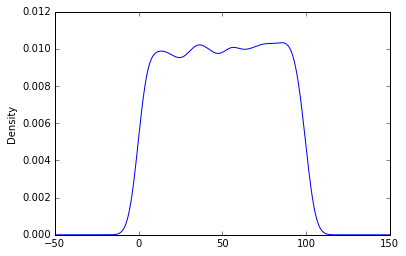

0.0: Garden_sqr_meter_per_person_in_residancy_area
0.0: Last_school_grades
0.0: Number_of_differnt_parties_voted_for
0.0: Political_interest_Total_Score
0.0: Number_of_valued_Kneset_members
0.0: Overall_happiness_score
0.0: Num_of_kids_born_last_10_years


In [9]:
from scipy.stats import shapiro
# print('scipy:', scipy.__version__)
i=0
not_normal =[]
for c in df.columns:
    if c not in ObjFeat:
        #lets test for normal distribution
        v=shapiro(df[c])[1]
        print str(v) + ": " + c
        if v>0:
            not_normal.append(c)            
            plot_density_function(df,c)
    i+=1

Looking at the distribution functions for the not normally distributed features, we see they are uniformly distributed, so let's transform them to normal distribution.

In [10]:
from scipy.stats import norm 
dfNormal = df.copy()
zero_to_one = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.001 and dfNormal[f].max()<1 and dfNormal[f].max()>0.999]
zero_to_ten = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.01 and dfNormal[f].max()<10 and dfNormal[f].max()>9.99]
zero_to_hundred = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.1 and dfNormal[f].max()<100 and dfNormal[f].max()>99.9]
for f in not_normal:    
    min= 0 if f in zero_to_one or f in zero_to_ten or f in zero_to_hundred else dfNormal[f].min()
    max= 1 if f in zero_to_one else (10 if f in zero_to_ten else 100 if f in zero_to_hundred else dfNormal[f].max())
#     print f + " max: "+str(max) + " min: " +str(min) + " max-min: " + str(max-min)
    dfNormal[f+"Normal"] = dfNormal[f].map(lambda x: norm.ppf((x-min)/(max-min)))     


In [11]:
dfNormal.head()

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,...,Financial_agenda_matters,Financial_balance_score_(0-1)Normal,%Of_Household_IncomeNormal,Avg_government_satisfactionNormal,Avg_education_importanceNormal,Avg_environmental_importanceNormal,Avg_Satisfaction_with_previous_voteNormal,Avg_monthly_income_all_yearsNormal,%Time_invested_in_workNormal,%_satisfaction_financial_policyNormal
0,9,9,901.074249,174664.625237,0,300.358083,0,581.521308,0,1,...,0,1.409976,-1.278801,-0.159726,-0.785160,0.243580,0.280940,1.207009,0.099971,-0.163179
1,7,4,172.175470,23146.728293,0,57.391823,0,403.310559,1,0,...,0,0.006143,0.101196,-0.510942,0.371065,-1.042274,0.441614,-0.093958,0.355765,-0.119097
2,8,3,408.262789,97198.945759,3,136.087596,0,714.238096,0,1,...,1,1.276014,-1.613368,-0.207336,-0.930039,-0.507376,1.541400,-1.125042,-0.535171,-0.655341
3,0,4,401.755874,52952.486970,2,133.918625,0,395.407936,1,1,...,0,0.767502,1.018157,-0.462479,-0.080996,-0.405040,-1.442237,-1.042580,-0.044586,-0.271335
4,0,5,210.935361,29798.270086,4,70.311787,0,423.801917,1,0,...,0,-0.586229,0.396308,-0.397577,-1.349092,-0.847130,-0.893416,1.262255,0.797462,-0.939317


#### getting rid of infinite values, we can't handle them, so we'll use the next best thing

In [12]:
dfNormal.replace([np.inf,-np.inf], np.nan, inplace=True)
dfNormal.dropna(inplace=True)

In [13]:
from scipy.stats import shapiro
i=0
not_normal =[]
for c in dfNormal.columns:    
    if c not in ObjFeat:
        #lets test for normal distribution        
        v=shapiro(dfNormal[c])[1]
        print str(v) + ": " + c
        if v>0:
            not_normal.append(c)                       
    i+=1

0.0: Occupation_Satisfaction
0.0: Avg_monthly_expense_when_under_age_21
0.0: AVG_lottary_expanses
0.0: Avg_Residancy_Altitude
0.0: Yearly_ExpensesK
2.10194769649e-44: Financial_balance_score_(0-1)
1.09301280217e-43: %Of_Household_Income
1.12103877146e-44: Avg_government_satisfaction
5.6051938573e-45: Avg_education_importance
2.80259692865e-44: Avg_environmental_importance
7.00649232162e-44: Avg_Satisfaction_with_previous_vote
3.78350585368e-44: Avg_monthly_income_all_years
2.38220738935e-44: %Time_invested_in_work
0.0: Yearly_IncomeK
0.0: Avg_monthly_expense_on_pets_or_plants
0.0: Avg_monthly_household_cost
0.0: Phone_minutes_10_years
0.0: Avg_size_per_room
0.0: Weighted_education_rank
1.26116861789e-44: %_satisfaction_financial_policy
0.0: Garden_sqr_meter_per_person_in_residancy_area
0.0: Last_school_grades
0.0: Number_of_differnt_parties_voted_for
0.0: Political_interest_Total_Score
0.0: Number_of_valued_Kneset_members
0.0: Overall_happiness_score
0.0: Num_of_kids_born_last_10_years

In [14]:
#what about the second assumption: The variance in each group is the same?
for vote in df.Vote.unique():
    print str(vote) + ":"  + str(df[df.Vote==vote]['Yearly_IncomeK'].var())
#or is it really the hipothesis and not an assumption? we should email him to understand if there's an error in the slides
#lets ignore it for now

9.0:1590.08292658
7.0:1125.5543959
8.0:46993.0960352
0.0:1584.52693781
4.0:13389.2867845
3.0:425.157292251
1.0:66960.7707982
2.0:53194.3004038
5.0:79685.5376568
6.0:9483.9057161


In [15]:
df_X_normal_dis_noNaN = dfNormal.drop(['Vote'], axis=1).values
df_Y_normal_dis_noNaN = dfNormal.Vote.values

In [16]:
import sklearn
v=sklearn.feature_selection.f_classif(df_X_normal_dis_noNaN, df_Y_normal_dis_noNaN)[1]
i=0
for c in dfNormal.drop(['Vote'], axis=1).columns:
    if c not in ObjFeat:        
        print  str(v[i]) + ": " + c
        if v[i]<alpha: #what is the null hipothesis? should we keep features with low value or high value?
            features_to_keep.append(c)            
    i+=1
    


0.100693168585: Occupation_Satisfaction
0.0: Avg_monthly_expense_when_under_age_21
0.0: AVG_lottary_expanses
0.0: Avg_Residancy_Altitude
0.0: Yearly_ExpensesK
0.846728099524: Financial_balance_score_(0-1)
0.318710955397: %Of_Household_Income
0.862299973271: Avg_government_satisfaction
0.661388235488: Avg_education_importance
0.904688082309: Avg_environmental_importance
0.456383472379: Avg_Satisfaction_with_previous_vote
0.316059150192: Avg_monthly_income_all_years
0.954652796041: %Time_invested_in_work
0.0: Yearly_IncomeK
0.0: Avg_monthly_expense_on_pets_or_plants
0.0: Avg_monthly_household_cost
0.0: Phone_minutes_10_years
0.0: Avg_size_per_room
0.0: Weighted_education_rank
0.152592065529: %_satisfaction_financial_policy
0.0: Garden_sqr_meter_per_person_in_residancy_area
0.0: Last_school_grades
0.995404433922: Number_of_differnt_parties_voted_for
0.0: Political_interest_Total_Score
0.147373413594: Number_of_valued_Kneset_members
0.0: Overall_happiness_score
0.440805493211: Num_of_kids_

In [17]:
features_to_keep

['Most_Important_Issue',
 'Looking_at_poles_results',
 'Married',
 'Will_vote_only_large_party',
 'Financial_agenda_matters',
 'Avg_monthly_expense_when_under_age_21',
 'AVG_lottary_expanses',
 'Avg_Residancy_Altitude',
 'Yearly_ExpensesK',
 'Yearly_IncomeK',
 'Avg_monthly_expense_on_pets_or_plants',
 'Avg_monthly_household_cost',
 'Phone_minutes_10_years',
 'Avg_size_per_room',
 'Weighted_education_rank',
 'Garden_sqr_meter_per_person_in_residancy_area',
 'Last_school_grades',
 'Political_interest_Total_Score',
 'Overall_happiness_score']

All the features that were uniformly distributed seem insignificant by this test, did we do anything wrong? 
<br><b>Yes, we apply the test with the wrong variables. Now we are using two vectors: </b>
1. vector X - feature vector without the lable
2. vector Y - lable vector

#### Lets compare mean by class, maybe we'll find more significant features:

In [18]:
import matplotlib.pyplot as plt
votes=df.Vote.unique()
votes.sort()
for c in df.columns:
    if c not in features_to_keep: #only look at features we still have'nt found any reason to keep    
        print c
        for vote in votes:
            print str(vote) + ": "  + str(df[df.Vote==vote][c].mean())
#         plt.plot(df[c])

Vote
0.0: 0.0
1.0: 1.0
2.0: 2.0
3.0: 3.0
4.0: 4.0
5.0: 5.0
6.0: 6.0
7.0: 7.0
8.0: 8.0
9.0: 9.0
Occupation_Satisfaction
0.0: 5.65298776098
1.0: 5.70588235294
2.0: 5.66260162602
3.0: 5.62634408602
4.0: 5.53096330275
5.0: 5.48131868132
6.0: 5.10810810811
7.0: 5.3164556962
8.0: 5.40118577075
9.0: 5.50045413261
Gender
0.0: 0.503239740821
1.0: 0.503267973856
2.0: 0.508130081301
3.0: 0.465053763441
4.0: 0.495412844037
5.0: 0.498901098901
6.0: 0.513513513514
7.0: 0.511754068716
8.0: 0.50790513834
9.0: 0.491825613079
Voting_Time
0.0: 0.472282217423
1.0: 0.503267973856
2.0: 0.55081300813
3.0: 0.509408602151
4.0: 0.491972477064
5.0: 0.47032967033
6.0: 0.513513513514
7.0: 0.528933092224
8.0: 0.51581027668
9.0: 0.510445049955
Financial_balance_score_(0-1)
0.0: 0.505608977156
1.0: 0.510374476973
2.0: 0.487457122845
3.0: 0.510175026716
4.0: 0.502358328319
5.0: 0.507855462793
6.0: 0.526831710406
7.0: 0.502821907378
8.0: 0.485645770253
9.0: 0.505902062979
%Of_Household_Income
0.0: 0.49117191753
1.0: 0.

Looks like people who vote for party 1 (whatever it was before we converted it to numbers) have higher value in Avg_monthly_expense_when_under_age_21. We can find more insights like this just from looking at the values above.
What to do next:
- find more insights like this -> more meaningful features
- Maybe find more tests (we could leave it for later) 
- Find features that are highly related to each other (same way we found features that are highly related to the label). Then maybe for each group, find the one that is most significant to the label, and use wrapper method to see if removing the others decrease performance of different classifiers.

Vote


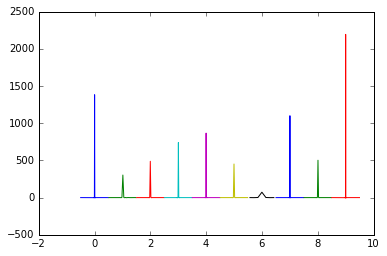

Occupation_Satisfaction


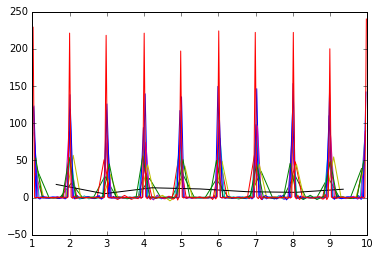

Gender


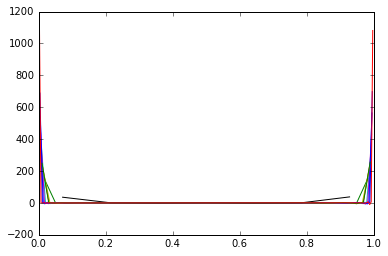

Voting_Time


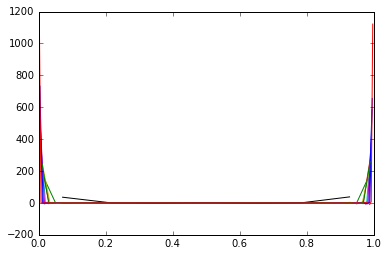

Financial_balance_score_(0-1)


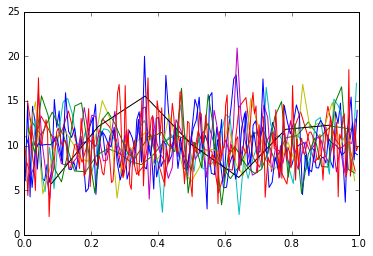

%Of_Household_Income


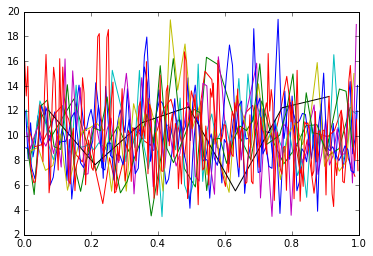

Avg_government_satisfaction


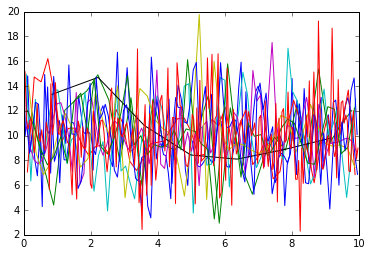

Avg_education_importance


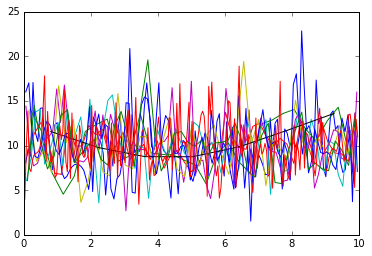

Avg_environmental_importance


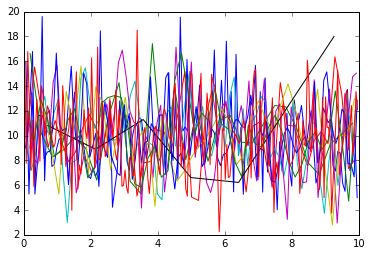

Avg_Satisfaction_with_previous_vote


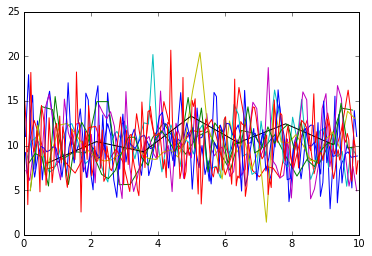

Avg_monthly_income_all_years


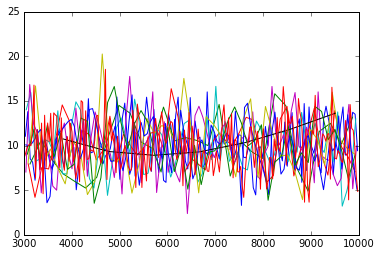

%Time_invested_in_work


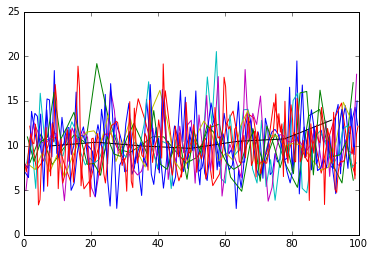

%_satisfaction_financial_policy


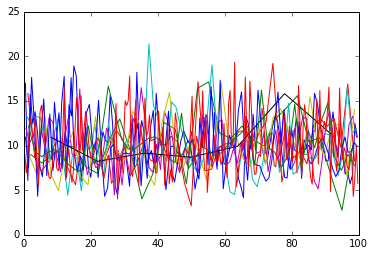

Age_group


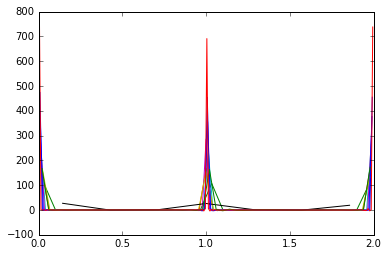

Number_of_differnt_parties_voted_for


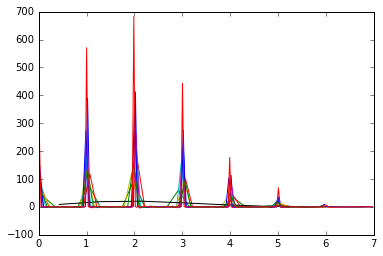

Number_of_valued_Kneset_members


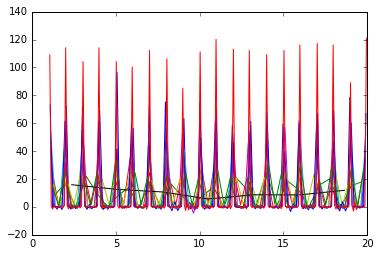

Main_transportation


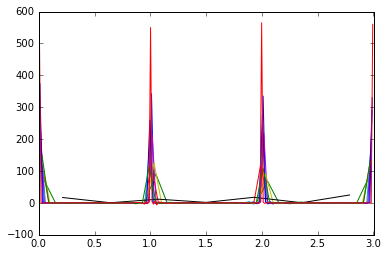

Occupation


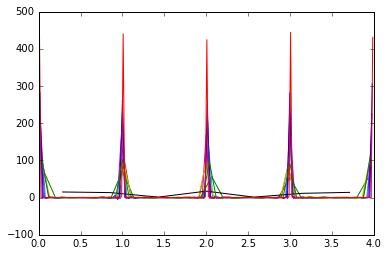

Num_of_kids_born_last_10_years


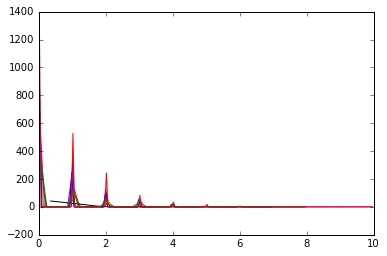

In [19]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

votes=df.Vote.unique()
votes.sort()

for c in df.columns:
    if c not in features_to_keep: #only look at features we still have'nt found any reason to keep    
        print c
        for vote in votes:
            s = df[df.Vote == vote][c].values
            N = len(s)
            n = N/10
            p, x = np.histogram(s, bins=n) # bin it into n = N/10 bins
            x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
            f = UnivariateSpline(x, p, s=n)
            plt.plot(x, f(x))

        plt.show()

### drop not selected features

In [20]:
not_selected_features = []
for c in df.columns:
    if c not in features_to_keep:
        not_selected_features.append(c)

df_selected_feat_X_noNaN = df.drop(not_selected_features, axis=1).values

In [21]:
print len(df_selected_feat_X_noNaN)
print len(df_Y_noNaN)
print len(df_X_noNaN)
print len(df)

8146
8146
8146
8146


## Wrappers (Features Selection)

### Training Random Forest Classifier - all features

In [22]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# Prepare train and test data using cross validation
X_train_noNaN, X_test_noNaN, y_train_noNaN, y_test_noNaN = train_test_split(df_X_noNaN, 
                                                                            df_Y_noNaN) 
                                                                            

# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 3)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(df_X_noNaN,df_Y_noNaN)

# output = forest.predict(test_data_noNaN)
y_pred_noNaN = forest.predict(X_test_noNaN)

print "accuracy:", metrics.accuracy_score(y_test_noNaN, y_pred_noNaN)
print "precision:", metrics.precision_score(y_test_noNaN, y_pred_noNaN)
print "recall:", metrics.recall_score(y_test_noNaN, y_pred_noNaN)
print "f1 score:", metrics.f1_score(y_test_noNaN, y_pred_noNaN)

accuracy: 0.963672066765
precision: 0.963766404662
recall: 0.963672066765
f1 score: 0.963672605003


/Users/Itay/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Itay/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1

### Training Random Forest Classifier - selected features

In [23]:
# Prepare train and test data using cross validation
X_train_noNaN, X_test_noNaN, y_train_noNaN, y_test_noNaN = train_test_split(df_selected_feat_X_noNaN, 
                                                                            df_Y_noNaN) 
                                                                            

# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 3)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(df_selected_feat_X_noNaN,df_Y_noNaN)

# output = forest.predict(test_data_noNaN)
y_pred_noNaN = forest.predict(X_test_noNaN)

print "accuracy:", metrics.accuracy_score(y_test_noNaN, y_pred_noNaN)
print "precision:", metrics.precision_score(y_test_noNaN, y_pred_noNaN)
print "recall:", metrics.recall_score(y_test_noNaN, y_pred_noNaN)
print "f1 score:", metrics.f1_score(y_test_noNaN, y_pred_noNaN)

accuracy: 0.971035837015
precision: 0.971216204459
recall: 0.971035837015
f1 score: 0.97107107879


/Users/Itay/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Itay/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1

### Create a K-Folds cross validation iterator

In [24]:
from sklearn.cross_validation import KFold

n_folds=5
kf = KFold(n=df_X_noNaN.shape[0], n_folds=n_folds)

print(kf) 

sklearn.cross_validation.KFold(n=8146, n_folds=5, shuffle=False, random_state=None)


### Train/Test Random Forest and SVM usin K-Fold cross validation - all features

In [25]:
from sklearn.svm import SVC

for k, (train_index, test_index) in enumerate(kf):
    # Random Forest
    forest = forest.fit(df_X_noNaN[train_index], df_Y_noNaN[train_index])
    y_pred_noNaN_RF = forest.predict(df_X_noNaN[test_index])
    #SVM
    clf = SVC().fit(df_X_noNaN[train_index], df_Y_noNaN[train_index])
    y_pred_noNaN_SVM = clf.predict(df_X_noNaN[test_index])
    
    #results    
    print("[fold {0}] RF score: {1:.5}, SVM score: {2:.5}".
          format(k, metrics.accuracy_score(df_Y_noNaN[test_index],y_pred_noNaN_RF), 
                 metrics.accuracy_score(df_Y_noNaN[test_index], y_pred_noNaN_SVM)))

[fold 0] RF score: 0.81656, SVM score: 0.27853
[fold 1] RF score: 0.79558, SVM score: 0.27624
[fold 2] RF score: 0.81522, SVM score: 0.26335
[fold 3] RF score: 0.80172, SVM score: 0.26826
[fold 4] RF score: 0.81584, SVM score: 0.26519


### Train/Test Random Forest and SVM usin K-Fold cross validation - selected features

In [26]:
for k, (train_index, test_index) in enumerate(kf):
    # Random Forest
    forest = forest.fit(df_selected_feat_X_noNaN[train_index], df_Y_noNaN[train_index])
    y_pred_noNaN_RF = forest.predict(df_selected_feat_X_noNaN[test_index])
    #SVM
    clf = SVC().fit(df_selected_feat_X_noNaN[train_index], df_Y_noNaN[train_index])
    y_pred_noNaN_SVM = clf.predict(df_selected_feat_X_noNaN[test_index])
    
    #results    
    print("[fold {0}] RF score: {1:.5}, SVM score: {2:.5}".
          format(k, metrics.accuracy_score(df_Y_noNaN[test_index],y_pred_noNaN_RF), 
                 metrics.accuracy_score(df_Y_noNaN[test_index], y_pred_noNaN_SVM)))

[fold 0] RF score: 0.83865, SVM score: 0.27853
[fold 1] RF score: 0.83118, SVM score: 0.27624
[fold 2] RF score: 0.83855, SVM score: 0.26335
[fold 3] RF score: 0.83425, SVM score: 0.26826
[fold 4] RF score: 0.8361, SVM score: 0.26519
